## 1. Entorno crudeTanksEnv

### 1.1. Establecer el entorno

En primer lugar cargaremos la librería __gym__ e inicializaremos el entorno.

In [1]:
if not ('isColab' in locals()):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        !pip install gymnasium
        !wget https://github.com/BaltiBoix/Scheduling/raw/master/tankEnvV2.py
        isColab = True
    else:
        print('Not running on CoLab')

Not running on CoLab


In [2]:
import gymnasium as gym
from gymnasium.spaces import flatten as flat
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from copy import deepcopy, copy
from collections import namedtuple, deque, OrderedDict
import os
import IPython.display
import sklearn
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler

import tankEnvV2

env = gym.envs.make('crudeTanksEnv-v2')

C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (2, 10)
  logger.warn(
C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (2, 5)
  logger.warn(
C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vec

In [3]:
print('Is torch cuda available?: {}'.format(torch.cuda.is_available()))

Is torch cuda available?: True


In [4]:
env.spec

EnvSpec(id='crudeTanksEnv-v2', entry_point=<class 'tankEnvV2.crudeTanksEnv'>, reward_threshold=700, nondeterministic=False, max_episode_steps=720, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='crudeTanksEnv', version=2)

In [5]:
flat(env.observation_space, env.observation_space.sample()).shape[0]

188

In [6]:
def flatFixData(env, t=0, nCargos=6):
    n = nCargos - len(env.S.cargo.sched.keys())
    if n > 0:
        fSched = n*12*[0.0]
    else:
        fSched = []
    for k, v in env.S.cargo.sched.items():
        fSched += [k-t] + [v.vol] + v.toDict()['comp']
    fAssay = env.S.unit.assay.reshape(-1)
    return np.concatenate((fSched, fAssay, env.S.unit.volCutMax), axis=-1)

In [7]:
state0, data = env.reset()
n_inputs = np.concatenate((flatFixData(env, env.S.t), flat(env.observation_space, state0)), axis=-1).shape[0]

C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float64, actual type: int32
  logger.warn(


In [8]:
flatFixData(env, 150).shape, n_inputs

((127,), 315)

In [9]:
crudeNames = np.array(['ARABIA LIGERO', 'BONNY LIGERO', 'BRASS RIVER', 'BRENT', 'CPC BLEND', 'DALIA', 
                       'PAZFLOR', 'SARIR', 'SIRTICA', 'ZAFIRO BLEND'])

assay = np.array(
    [[0.2083, 0.2503, 0.3046, 0.286 , 0.3979, 0.0596, 0.0843, 0.2039, 0.3133, 0.1962],
    [0.1639, 0.1502, 0.17  , 0.1457, 0.187 , 0.1094, 0.0978, 0.1249, 0.1546, 0.1427],
    [0.22  , 0.3191, 0.289 , 0.2297, 0.2281, 0.253 , 0.2845, 0.232, 0.2341, 0.2863],
    [0.2209, 0.2094, 0.1862, 0.2114, 0.1351, 0.3135, 0.2804, 0.2541, 0.1819, 0.2339],
    [0.1869, 0.071 , 0.0502, 0.1272, 0.0519, 0.2645, 0.253 , 0.1851, 0.1161, 0.1409]]
)
        
unitVolCutMax = np.array([0.25, 0.2, 0.4, 0.3, 0.2])

In [10]:
with open('siteDict.json', 'r') as f:
    siteDict = json.load(f) 

# assay = None
# unitVolCutMax = None
siteDict = None
    
#state0, fixDict = env.reset(siteDict=siteDict)
# state0, fixDict = env.reset(assay=assay, unitVolCutMax=unitVolCutMax)


### Agente Dueling DQN

En este apartado resolveremos el mismo entorno con las mismas características para el agente, pero usando una dueling DQN. Como en el caso anterior, primero definiremos el modelo de red neuronal, luego describiremos el comportamiento del agente, lo entrenaremos y, finalmente, testearemos el funcionamiento del mismo.

### Definición de la arquitectura  de la red neuronal

El objetivo principal de las dueling DQN es "ahorrarse" el cálculo del valor de Q en aquéllos estados en los que es irrelevante la acción que se tome. Para ello se descompone la función Q en dos componentes:


$$Q(s, a) = A(s, a) + V (s)$$


Esta descomposición se realiza a nivel de la arquitectura de la red neuronal. Las primeras capas que teníamos en la DQN serán comunes, y luego la red se dividirá en dos partes separadas definidas por el resto de capas.

La descomposición en sub-redes del modelo de la DQN implementada en el apartado anterior, será entonces:
<ol>
    <li>Bloque común, la red CNN</li>
    <li>Red advantage A(s,a):</li>
         <ul>

In [11]:
class duelingDQN(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cuda'):
        """
        Params
        ======
        input_shape: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        device: cpu o cuda
        red_cnn: definición de la red convolucional
        value: definición de la red lineal value
        advantage: definición de la red lineal advantage
        """

        super(duelingDQN, self).__init__()

        if device=='cuda' and torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.n_inputs = n_inputs #flat(env.observation_space, env.observation_space.sample()).shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
            

        self.red_lineal = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),        
            torch.nn.Linear(512, 1024, bias=True),
            torch.nn.ReLU(),        
            torch.nn.Linear(1024, 512, bias=True),
            torch.nn.ReLU()        
        )
        
        self.advantage = torch.nn.Sequential(
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),        
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),        
            torch.nn.Linear(256, self.n_outputs, bias=True)
        )
        
        self.value = torch.nn.Sequential(
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),        
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),        
            torch.nn.Linear(128, 1, bias=True)
        )

        ### Se ofrece la opción de trabajar con cuda
        if self.device == 'cuda':
            self.red_lineal.cuda()
            self.value.cuda()
            self.advantage.cuda()

        ### Inicializamos el optimizador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
#         self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', patience=25000,
#                                                                    factor=0.5, min_lr=0.00001, verbose=True)

    def forward(self, x):
        out = self.red_lineal(x)
        adv = self.advantage(out)
        out = self.value(out) + adv
        return out

    ### Método e-greedy
    def get_action(self, state, actionAvail, epsilon=0.05):
        if np.random.random() < epsilon:
            if actionAvail.any():
                action = np.random.choice([i for i, b in enumerate(actionAvail) if b])
            else:
                action = 0
        else:
            qvals = self.get_qvals(state)  # acción a partir del cálculo del valor de Q para esa acción
            action= torch.max(qvals * torch.tensor(actionAvail+1E-5, device=self.device), dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.forward(state_t)

####  _Buffer_ de repetición de experiencias

In [12]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    ##Creamos una lista de índices aleatorios y empaquetamos las experiencias en arrays de Numpy (facilita el cálculo posterior de la pérdida)
    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    ## Se añaden las nuevas experiencias 
    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    ## Rellenamos el buffer con experiencias aleatorias al inicio del entrenamiento
    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

### Definición del agente

In [13]:
class duelingDQNAgent:

    def __init__(self, env, assay, unitVolCutMax, seed,
                 main_network, buffer,
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock=100):
        """"
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        target_network: red objetivo
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.assay = assay
        self.unitVolCutMax = unitVolCutMax
        self.seed = seed
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock
        self.reward_threshold = env.spec.reward_threshold
        self.mean_rewards = -10000.
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.epsilons = []
        self.losses = []
        self.initialize()

    def initialize(self):
        self.total_reward = 0
        self.step_count = 0
        state, self.data = self.env.reset(seed=self.seed, assay=self.assay, unitVolCutMax=self.unitVolCutMax)
        self.state0 = np.concatenate((flatFixData(self.env), flat(self.env.observation_space, state)), axis=-1)
        self.actionAvail = self.data['actionAvail']

    def take_step(self, eps, mode='train'):
        if mode == 'explore':
#             action = self.env.action_space.sample()  # acción aleatoria en el burn-in
            action = np.random.choice([i for i, b in enumerate(self.actionAvail) if b])
        else:
            action = self.main_network.get_action(self.state0, self.actionAvail, eps)# acción a partir del valor de Q (elección de la acción con mejor Q)
        self.step_count += 1

        new_state, reward, done, truncated, info = self.env.step(action)
        new_state = np.concatenate((flatFixData(self.env, self.env.S.t), flat(self.env.observation_space, new_state)), axis=-1)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiencia en el buffer
        self.state0 = deepcopy(new_state)
        self.actionAvail = info['actionAvail']

        return done

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        maximo = -10000.0
        while training:
            state0, self.data = self.env.reset(seed=self.seed, assay=self.assay, unitVolCutMax=self.unitVolCutMax)
            self.state0 = np.concatenate((flatFixData(self.env), flat(self.env.observation_space, state0)), axis=-1)
            self.actionAvail = self.data['actionAvail']
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')

                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())

            episode += 1
            self.epsilons.append(self.epsilon)
            if len(self.update_loss):
                self.losses.append(self.update_loss[-1])
            self.training_rewards.append(self.total_reward) # guardamos las recompensas obtenidas
            if self.total_reward > maximo:
                maximo = self.total_reward
                self.maxS = deepcopy(self.env.S)

            self.update_loss = []

            self.mean_rewards = np.mean(self.training_rewards[-self.nblock:])
            self.mean_training_rewards.append(self.mean_rewards)                    

#             if self.epsilon == min_epsilon and self.mean_rewards < self.mean_training_rewards[-self.nblock]:
#                 self.epsilon = 0.5
#                 print("reinitialize epsilon")

            if episode > 100 and episode % 100 == 0:
                self.plot_rewards()

            print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {:.4f} , Maximo {:.2f}\t\t".format(
                episode, self.mean_rewards, self.epsilon, maximo), end="")

            # Comprobar si se ha llegado al máximo de episodios
            if episode >= max_episodes:
                training = False
                print('\nEpisode limit reached.')
                break


            # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
            # y se ha entrenado un mínimo de episodios
            if self.mean_rewards >= self.reward_threshold and min_episodios <  episode:
                training = False
                print('\nEnvironment solved in {} episodes!'.format(
                    episode))
                break

            self.epsilon =  max(self.epsilon * self.eps_decay, min_epsilon)


     ## Cálculo de la pérdida
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device).reshape(-1,1)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(
            device=self.device)
        dones_t = torch.BoolTensor(dones).to(device=self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)

        #DQN update#
        next_actions = torch.max(self.main_network.get_qvals(next_states), dim=-1)[1]
        next_actions_vals = next_actions.reshape(-1,1).to(device=self.device)
        # Obtenemos los valores de Q de la red objetivo
        target_qvals = self.target_network.get_qvals(next_states)
        qvals_next = torch.gather(target_qvals, 1, next_actions_vals) #.detach()

        qvals_next[dones_t] = 0 # 0 en estados terminales

        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss



    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
#         self.main_network.lr_sched.step(self.mean_rewards)
        # Guardamos los valores de pérdida
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

    def plot_rewards(self):
      
        IPython.display.clear_output(wait=True)

        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.env.spec.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.grid()
        plt.show()

### 3.3 Entrenamiento

A continuación entrenaremos el modelo dueling DQN con los mismos hiperparámetros con los que entrenamos la DQN.

In [14]:
lr = 1.E-4            #Velocidad de aprendizaje
BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 10000   #Máxima capacidad del buffer
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .99   #Decaimiento de epsilon
MIN_EPSILON = 0.02    #Mínimo epsilon
NBLOCK = 100          #Número de steps para rellenar el buffer
MAX_EPISODES = 5000   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
MIN_EPISODIOS = 500   #Número mínimo de episodios
BURN_IN = 2000        #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
DNN_UPD = 1           #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 1500       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

In [15]:
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

In [16]:
ddqn = duelingDQN(env, n_inputs, learning_rate=lr)

In [17]:
dagent = duelingDQNAgent(env, assay, unitVolCutMax, 200560, ddqn, buffer, EPSILON, EPSILON_DECAY, BATCH_SIZE, NBLOCK)

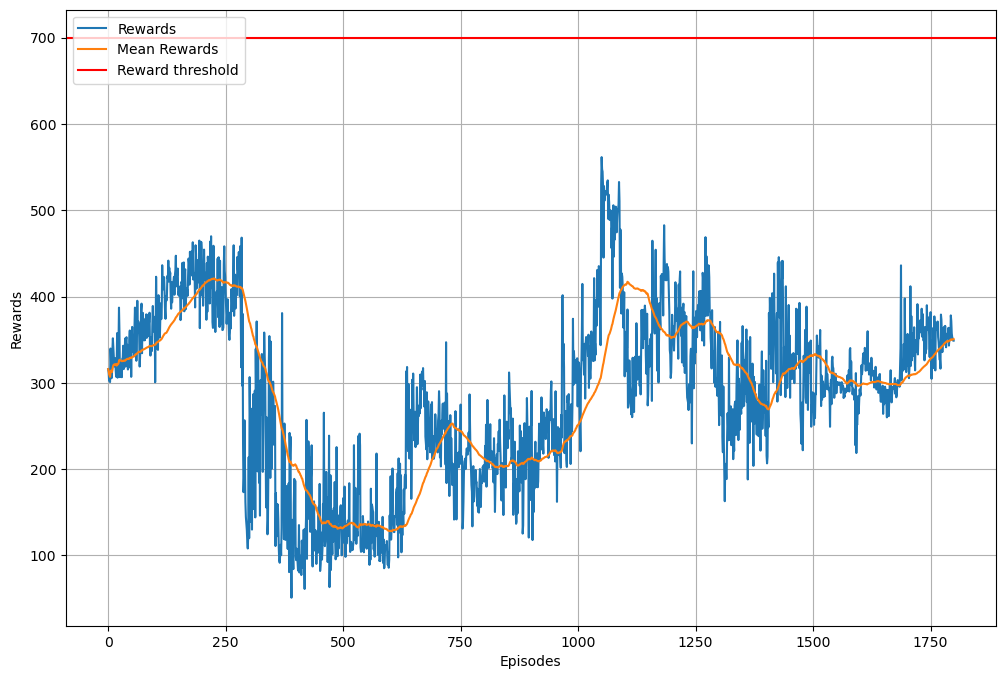

Episode 1875 Mean Rewards 353.40 Epsilon 0.0200 , Maximo 561.64		

KeyboardInterrupt: 

In [18]:
%%time

dagent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
             batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, 
             dnn_sync_frequency=DNN_SYNC, min_episodios=MIN_EPISODIOS, min_epsilon=MIN_EPSILON)

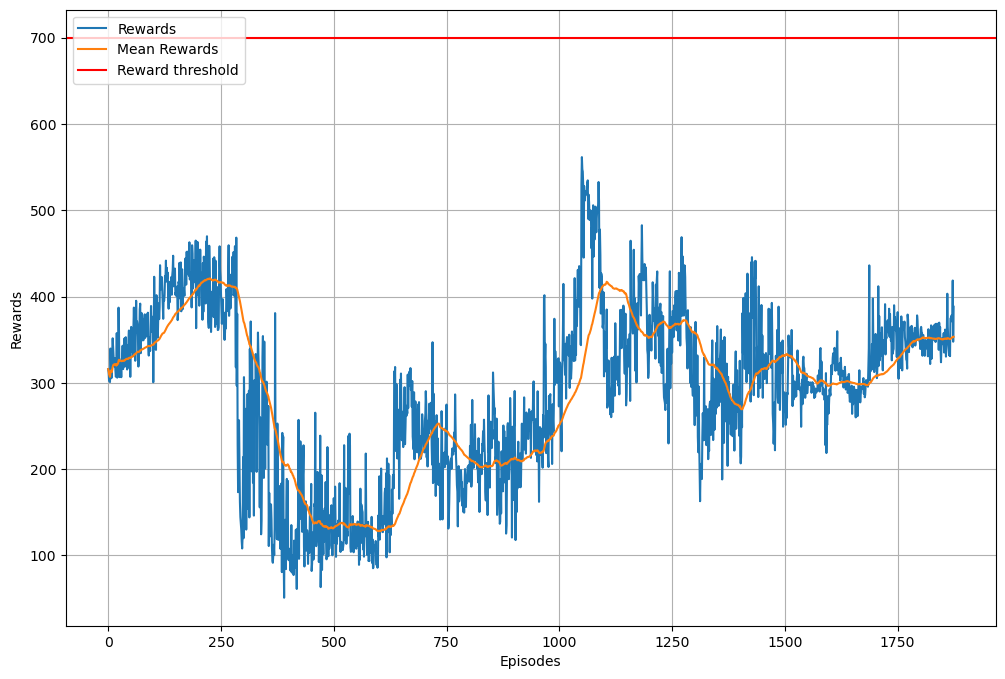

In [19]:
dagent.plot_rewards()

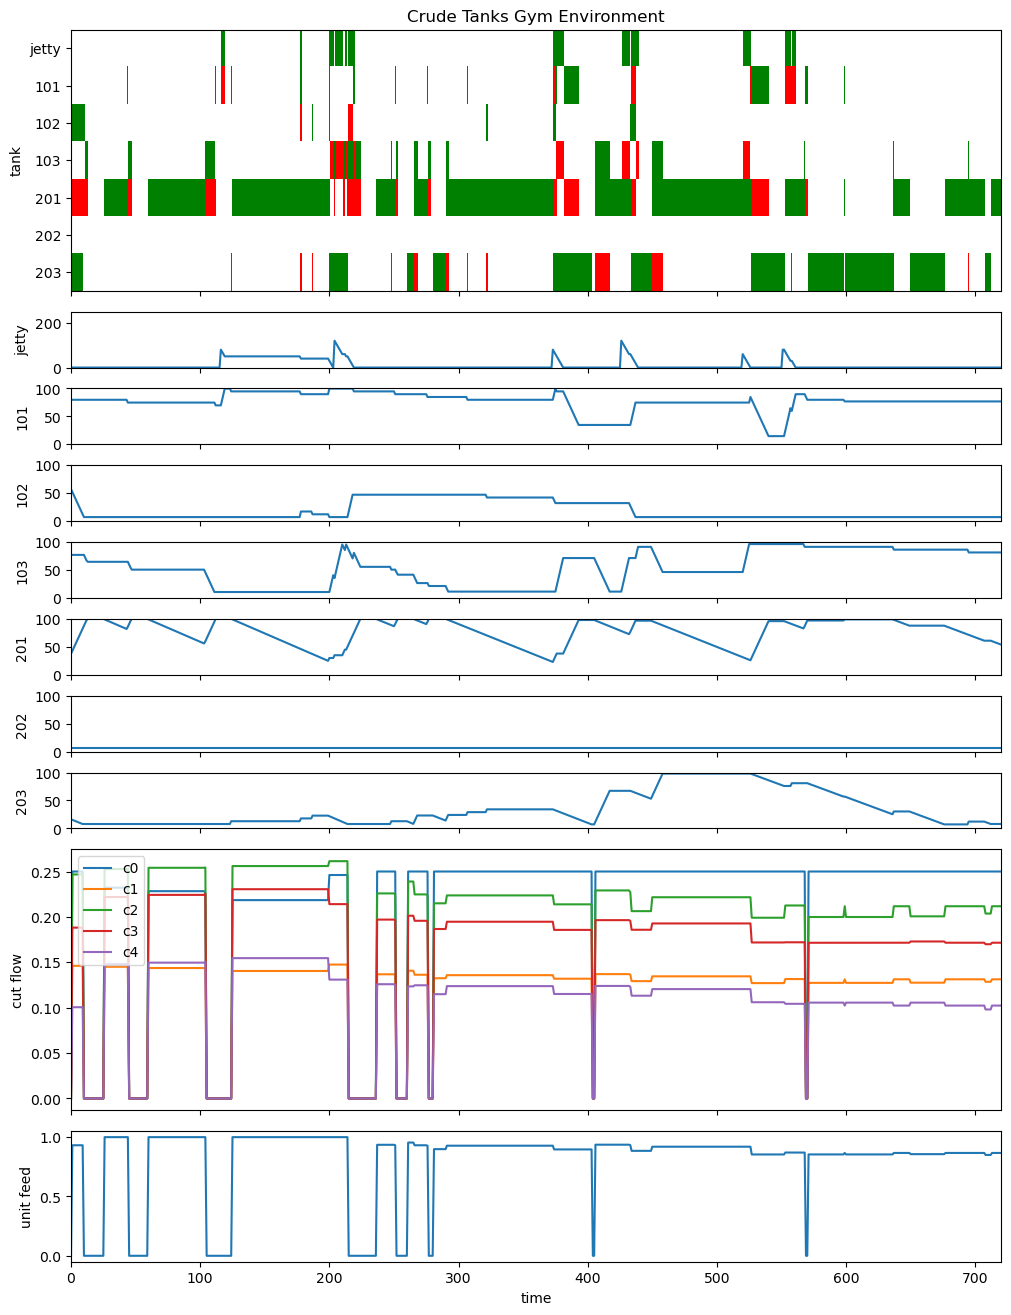

In [20]:
dagent.maxS.render()

In [21]:
myfile = 'agentDDQN_Trained_Model.pth'
if os.path.isfile(myfile):
    os.remove(myfile)
torch.save(ddqn.state_dict(), myfile)

98.48445472160975


CPU times: total: 2.02 s
Wall time: 2.02 s


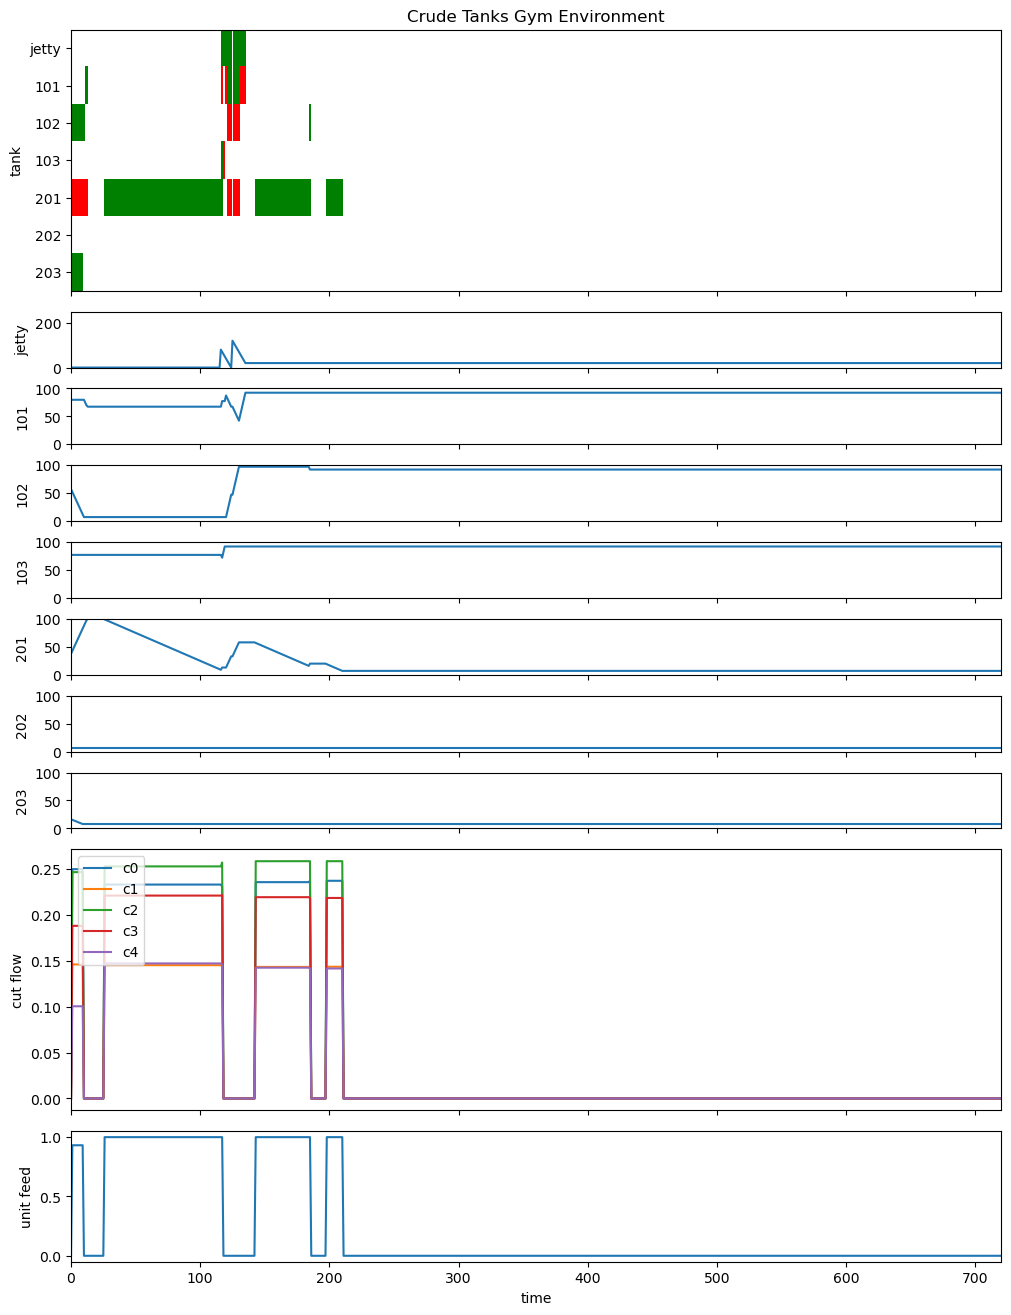

In [26]:
%%time

env = gym.envs.make('crudeTanksEnv-v2')

d_dqn = duelingDQN(env, n_inputs, device='cuda')
d_dqn.load_state_dict(torch.load(myfile))

seed = 200560

state, data = env.reset(seed=seed, assay=assay, unitVolCutMax=unitVolCutMax)
state0 = np.concatenate((flatFixData(env), flat(env.observation_space, state)), axis=-1)
actionAvail = data['actionAvail']
done = False
episode_reward = 0
n = 0
action_list = []
while not done:
    action= torch.max(d_dqn.get_qvals(state0) * torch.tensor(actionAvail+1E-5, device=d_dqn.device), dim=-1)[1].item()
    action_list.append(action)
    state, reward, done, truncated, info = env.step(action)
    actionAvail = info['actionAvail']
    episode_reward += reward
    n += 1
    state0 = np.concatenate((flatFixData(env), flat(env.observation_space, state)), axis=-1)

print(episode_reward)
env.render()
print('\n')

In [23]:
data

{'sched': {116: vol:  80.00 comp: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.],
  125: vol: 120.00 comp: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.],
  373: vol:  80.00 comp: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.],
  426: vol: 120.00 comp: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.],
  520: vol:  60.00 comp: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.],
  551: vol:  80.00 comp: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]},
 'assay': array([[0.2083, 0.2503, 0.3046, 0.286 , 0.3979, 0.0596, 0.0843, 0.2039,
         0.3133, 0.1962],
        [0.1639, 0.1502, 0.17  , 0.1457, 0.187 , 0.1094, 0.0978, 0.1249,
         0.1546, 0.1427],
        [0.22  , 0.3191, 0.289 , 0.2297, 0.2281, 0.253 , 0.2845, 0.232 ,
         0.2341, 0.2863],
        [0.2209, 0.2094, 0.1862, 0.2114, 0.1351, 0.3135, 0.2804, 0.2541,
         0.1819, 0.2339],
        [0.1869, 0.071 , 0.0502, 0.1272, 0.0519, 0.2645, 0.253 , 0.1851,
         0.1161, 0.1409]]),
 'unitVolCutMax': array([0.25, 0.2 , 0.4 , 0.3 , 0.2 ]),
 'actionAvail': array([False,  True, False,  True, False, False,  True, False, 

In [24]:
%%time

env = gym.envs.make('crudeTanksEnv-v2')

d_dqn = duelingDQN(env, n_inputs, device='cuda')
d_dqn.load_state_dict(torch.load(myfile))

reward_list = []
n_list = []
for n_episodes in range(20):
    state, data = env.reset()
    state0 = np.concatenate((flatFixData(env), flat(env.observation_space, state)), axis=-1)

    actionAvail = data['actionAvail']
    done = False
    episode_reward = 0
    n = 0
    action_list = []
    while not done:
        action= torch.max(d_dqn.get_qvals(state0) * torch.tensor(actionAvail+1E-5, device=d_dqn.device), dim=-1)[1].item()
        action_list.append(action)
        state, reward, done, truncated, info = env.step(action)
        actionAvail = info['actionAvail']
        episode_reward += reward
        n += 1
        state0 = np.concatenate((flatFixData(env), flat(env.observation_space, state)), axis=-1)
    a, b = np.unique(action_list, return_counts=True)
    txt = ' '.join(['{:2d}: {:3d} |'.format(x, y) for x, y in zip(a, b)])
    print('{:2d} n: {:4d}   reward: {:4.0f}   Action Freq {}'.format(n_episodes+1, n, episode_reward, txt))
    n_list.append(n)
    reward_list.append(episode_reward)
print('\n')

 1 n:  720   reward:  154   Action Freq  0: 291 |  1: 153 |  2:  29 |  7: 176 |  8:  28 | 14:   1 | 15:  11 | 31:  13 | 48:   1 | 57:   8 | 76:   2 | 77:   7 |
 2 n:  720   reward:  268   Action Freq  0: 110 |  1: 234 |  2:  33 |  3:  26 |  7:  18 |  9:   1 | 16:  92 | 17:  30 | 25: 123 | 27:  11 | 31:  11 | 39:   2 | 47:   6 | 48:   1 | 53:   4 | 57:   8 | 75:   3 | 77:   6 | 78:   1 |
 3 n:  720   reward:  264   Action Freq  0:  94 |  1: 192 |  2:  56 |  3:  32 |  7: 227 | 15:   8 | 17:  35 | 25:  36 | 31:  24 | 57:   9 | 60:   2 | 75:   5 |
 4 n:  720   reward:  442   Action Freq  0:  91 |  1: 419 |  2:  25 |  4:  14 |  7:  48 | 14:   7 | 16:  28 | 17:   9 | 18:  19 | 25:  15 | 27:   3 | 31:   2 | 47:  12 | 57:   9 | 58:   5 | 75:  11 | 77:   3 |
 5 n:  720   reward:  194   Action Freq  0: 444 |  1: 183 |  2:   9 |  3:  16 | 14:   7 | 18:   3 | 27:  34 | 31:   5 | 55:   4 | 57:   8 | 75:   3 | 77:   4 |
 6 n:  720   reward:  390   Action Freq  0:  25 |  1: 447 |  2:  32 |  3:   5 | 

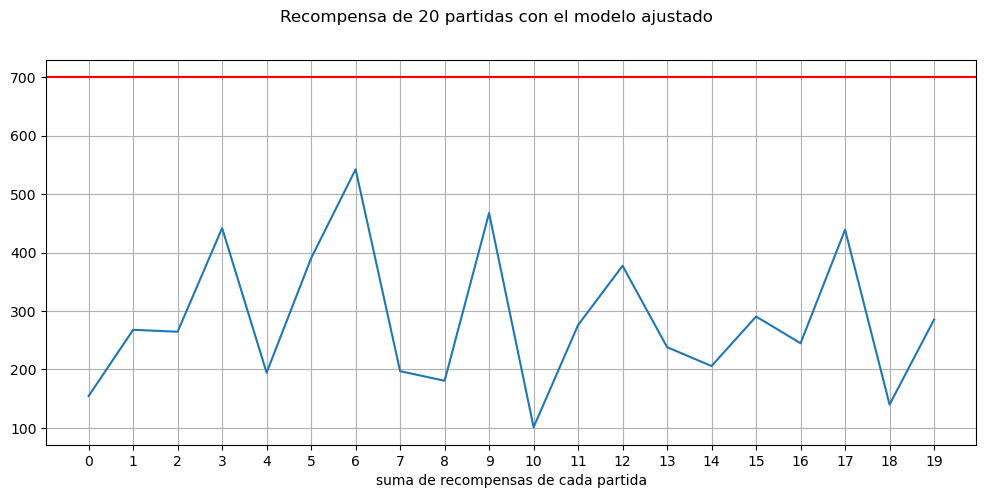

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))

fig.suptitle('Recompensa de 20 partidas con el modelo ajustado')

ax.plot(reward_list)
ax.axhline(y=env.spec.reward_threshold, color='r', linestyle='-')
ax.set_xlabel('suma de recompensas de cada partida')
ax.set_xticks(range(20))
ax.grid()

plt.show()